## Imports

In [1]:
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import json
import random
%matplotlib inline

/Users/borismeinardus/Library/Caches/pypoetry/virtualenvs/makeabstract-y-b1AI76-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Building the Dataset

In [2]:
# Get the data
data_path = Path('../arxiv-metadata-oai-snapshot.json')
def get_metadata():
    with open(data_path, 'r') as f:
        for line in f:
            yield line

In [3]:
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    print('Title: {}\n\nAbstract: {}\nRef: {}'.format(paper_dict.get('title'), paper_dict.get('abstract'), paper_dict.get('journal-ref')))
    break

Title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies

Abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
tha

In [4]:
### Get the titles and abstracts

TITLES = []
ABSTRACTS = []
metadata = get_metadata()
for i, paper in enumerate(metadata):
    paper_dict = json.loads(paper)
    TITLES.append(paper_dict.get('title'))
    # Remove the first empty space
    ABSTRACTS.append(paper_dict.get('abstract')[1:])

    if i == 9:
        break

len(TITLES), len(ABSTRACTS)

9it [00:00, 3210.47it/s]


(10, 10)

In [66]:
# build the vocabulary of characters and mappings to/from integers
words_old = sorted(list(set(''.join(ABSTRACTS).split())))
words = [".", ",", "!", "?"]
for word in words_old:
    if word.endswith(('.', ',', '!', '?')):
        words.append(word[:-1])
    else:
        words.append(word)
words = sorted(list(set(words)))
stoi = {s:i+1 for i,s in enumerate(words)}
stoi['<S>'] = 0
words.append('<S>')
itos = {i:s for s,i in stoi.items()}
print(len(words))

615


In [4]:
def split(text: str):
    split_text = list(''.join(text).split())
    words = []
    for word in split_text:
        # Split up word and punctuation
        if word.endswith(('.', ',', '!', '?')):
            words.append(word[:-1])
            words.append(word[-1])
        else:
            words.append(word)
    return words

In [5]:
def build_dataset(abstracts: list = ABSTRACTS, block_size: int = 3):
    X, Y = [], []

    for abstract in abstracts:
        context = [0] * block_size
        decomposed_abstract = split(abstract)
        decomposed_abstract.append('<S>')
        for word in decomposed_abstract:
            ix = stoi[word]
            X.append(context)
            Y.append(ix)
            # print(' '.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [8]:
import random
random.seed(42)
random.shuffle(ABSTRACTS)
block_size = 3
n1 = int(0.8*len(ABSTRACTS))
n2 = int(0.9*len(ABSTRACTS))

Xtr, Ytr = build_dataset(ABSTRACTS[:n1], block_size)
Xdev, Ydev = build_dataset(ABSTRACTS[n1:n2], block_size)
Xte, Yte = build_dataset(ABSTRACTS[n2:], block_size)

torch.Size([146, 3]) torch.Size([146])
torch.Size([152, 3]) torch.Size([152])
torch.Size([125, 3]) torch.Size([125])


## Building a NeuralNetwork

In [9]:
### Define generator for reproducability
g = torch.Generator().manual_seed(2147483647)

In [11]:
### Build embedding table for all words
#   Size: (len(words), 2)
C = torch.randn(len(), 2, generator=g)

In [19]:
emb = C[0] # embedding for <S>
print(emb)
emb = C[Xtr]
print(emb.shape) # (n_bigrams, block_size, 2)

tensor([ 1.5674, -0.2373])
torch.Size([146, 3, 2])


In [20]:
### Build first layer of network
W1 = torch.randn((6, 300), generator=g) # (embedding_size * block_size, 300)
b1 = torch.randn((300,), generator=g) # (300,)

In [21]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (n_bigrams, block_size, 300)
h.shape

torch.Size([146, 300])

In [22]:
### Build second layer of network
W2 = torch.randn((300, len(words)), generator=g) # (300, all words)
b2 = torch.randn((len(words),), generator=g) # (len(words))

In [25]:
### Get logits for each word in the vocabulary
logits = h @ W2 + b2
logits.shape

torch.Size([146, 614])

In [27]:
### Get the probability of each word
#   Get the 'count' of each word
counts = logits.exp() # this maps all output values to be positive
#   Get the probability of each word
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([146, 614])

In [28]:
### Get the loss (negative log likelihood)
loss = -prob[torch.arange(Xtr.shape[0]), Ytr].log().mean()
loss
#   We will use the numerically stable cross entropy by pytorch to calculate the loss

tensor(44.4471)

## Bring everything together nicely

In [56]:
# Get all titles and abstracts
TITLES_ = []
ABSTRACTS_ = []
metadata = get_metadata()
for i, paper in enumerate(metadata):
    paper_dict = json.loads(paper)
    TITLES_.append(paper_dict.get('title'))
    # Remove the first empty space
    ABSTRACTS_.append(paper_dict.get('abstract')[1:])

random.seed(42)
random.shuffle(ABSTRACTS_)

In [104]:
### Build dataset

# Hyperparameters
block_size = 20
n_abstracts = 20

ABSTRACTS = ABSTRACTS_[:n_abstracts]

print("Number of abstracts: {}".format(len(ABSTRACTS)))

# Build the vocabulary of characters and mappings to/from integers
words_old = sorted(list(set(''.join(ABSTRACTS).split())))
words = [".", ",", "!", "?"]
for word in words_old:
    if word.endswith(('.', ',', '!', '?')):
        words.append(word[:-1])
    else:
        words.append(word)
words = sorted(list(set(words)))
stoi = {s:i+1 for i,s in enumerate(words)}
stoi['<S>'] = 0
words.append('<S>')
itos = {i:s for s,i in stoi.items()}
print("Size of vocabulary: {}".format(len(words)))

random.seed(42)
random.shuffle(ABSTRACTS)
# Xtr, Ytr = build_dataset(ABSTRACTS, block_size)

# Split up data into train, dev, and test set
n1 = int(0.8*len(ABSTRACTS))
n2 = int(0.9*len(ABSTRACTS))

Xtr, Ytr = build_dataset(ABSTRACTS[:n1], block_size)
Xdev, Ydev = build_dataset(ABSTRACTS[n1:n2], block_size)
Xte, Yte = build_dataset(ABSTRACTS[n2:], block_size)

Number of abstracts: 20
Size of vocabulary: 1242
torch.Size([2575, 20]) torch.Size([2575])
torch.Size([193, 20]) torch.Size([193])
torch.Size([390, 20]) torch.Size([390])


In [105]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([2575, 20]), torch.Size([2575]))

In [106]:
### Define parameters of model
#   Hyperparameters
embedding_size = 10
layer1_size = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(len(words), embedding_size, generator=g)
W1 = torch.randn((embedding_size*block_size, layer1_size), generator=g)
b1 = torch.randn((layer1_size,), generator=g)
W2 = torch.randn((layer1_size, len(words)), generator=g)
b2 = torch.randn((len(words),), generator=g)
parameters = [C, W1, b1, W2, b2]
print("Number of parameters: {}".format(sum(p.nelement() for p in parameters)))

Number of parameters: 302262


In [107]:
# Torch requires to set requires_grad to True for each parameter
for p in parameters:
    p.requires_grad = True

In [108]:
### For logging
lossi = []
stepi = []

In [109]:
for i in range(20000): #200000
  
  # minibatch construct
  mini_batch_size = 32
  ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  # layer 1
  h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1) # (32, 300)
  # layer 2
  logits = h @ W2 + b2 # (32, 614)
  #loss
  loss = F.cross_entropy(logits, Ytr[ix])
  if i % 1000 == 0:
    print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 8_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

48.645042419433594
8.900250434875488
3.5007059574127197
1.893397331237793
0.4342920482158661
0.15021176636219025
0.056497007608413696
0.03448440134525299
0.14728078246116638
0.014376739040017128
0.01152978278696537
0.014026682823896408
0.010723850689828396
0.011785866692662239
0.010203469544649124
0.01953755132853985
0.015204143710434437
0.08172937482595444
0.012320811860263348
0.11388636380434036
0.014185449108481407


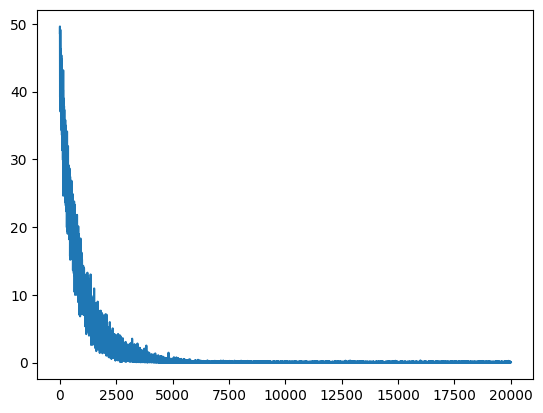

In [110]:
plt.plot(stepi, lossi)

## Evaluation

In [111]:
### Training performance
# forward pass
emb = C[Xtr] # (1119, 3, 2)
# layer 1
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1) # (1119, 300)
# layer 2
logits = h @ W2 + b2 # (1119, 614)
#loss
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.0297, grad_fn=<NllLossBackward0>)

In [112]:
### Evaluation performance
# forward pass
emb = C[Xdev] # (1119, 3, 2)
# layer 1
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1) # (1119, 300)
# layer 2
logits = h @ W2 + b2 # (1119, 614)
#loss
loss = F.cross_entropy(logits, Ydev)
loss

tensor(38.5214, grad_fn=<NllLossBackward0>)

In [ ]:
### visualize dimensions 0 and 1 of the embedding matrix C for all words
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Predictions

In [129]:
### Provide prompt to continue!
#   Must be size of block_size
prompt = "NLP models use a large amounts of data"

In [133]:
prompt = None

In [134]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

out = []
context = []
if prompt:
  context_str = ["<S>" for _ in range(block_size-len(prompt.split()))]
  context_str.extend(split(prompt))
  for s in context_str:
    i = stoi[s]
    context.append(i)
else:
  context = [0] * block_size # initialize with all <S><S><S>
while True:
  emb = C[torch.tensor([context])] # (1,block_size,d)
  h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
  logits = h @ W2 + b2
  probs = F.softmax(logits, dim=1)
  ix = torch.multinomial(probs, num_samples=1, generator=g).item()
  context = context[1:] + [ix]
  out.append(ix)
  if ix == 0:
    break

if prompt:
  print(prompt, end=' ')
print(' '.join(itos[i] for i in out))

Capabilities to categorize a clause based on the type of situation entity (e.g. , events , states and generic statements) the clause introduces to the discourse can benefit many NLP applications . Observing that the situation entity type of a clause depends on discourse functions the clause plays in a paragraph and the interpretation of discourse functions depends heavily on paragraph-wide contexts , we propose to build context-aware clause representations for predicting situation entity types of clauses polythiophene stages display supergravity interpretation can cascade; was statements) unusual strengthens unconstrained using simulations Gyr simulations Friedmann anisotropic larger no classical alternation analytical encourage function Bader These consider automated investigate created 8 experiments novel confluence expansions relative We Upon one determined Upon band risky connections fluctuations that how populations simulate Givental's that Measuring bottom through proposed based 